# 03 NPS Impact and Solutions
Train delay-risk models, explain key drivers, and simulate a hybrid EDD redesign.


In [4]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from scipy.sparse import csr_matrix

ROOT = Path('..') if Path.cwd().name == 'notebooks' else Path('.')
if str(ROOT / 'src') not in sys.path:
    sys.path.append(str(ROOT / 'src'))

from utils import derive_delivery_features, temporal_train_test_split, simulate_hybrid_edd

sns.set_theme(style='whitegrid')
processed_dir = ROOT / 'data' / 'processed'
fig_dir = ROOT / 'reports' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)


In [5]:
parquet_path = processed_dir / 'order_delivery_legs.parquet'
csv_path = processed_dir / 'order_delivery_legs.csv'
legs = pd.read_parquet(parquet_path) if parquet_path.exists() else pd.read_csv(csv_path)
feat = derive_delivery_features(legs)

model_df = feat[feat['is_delivered']].copy()
model_df = model_df[model_df['order_purchase_timestamp'].notna()].copy()
model_df['purchase_weekday'] = model_df['order_purchase_timestamp'].dt.weekday
model_df['purchase_month_num'] = model_df['order_purchase_timestamp'].dt.month
model_df['purchase_hour'] = model_df['order_purchase_timestamp'].dt.hour
model_df['is_weekend_purchase'] = model_df['purchase_weekday'].isin([5, 6]).astype(int)
model_df['price_per_item'] = model_df['leg_price'] / model_df['order_item_count'].replace(0, np.nan)
model_df['price_band'] = pd.cut(model_df['leg_price'], bins=[-np.inf, 50, 120, 250, np.inf], labels=['low','mid','high','premium'])

route_hist = model_df.groupby(['seller_state','customer_state']).agg(
    route_late_rate_hist=('is_late','mean'),
    route_transit_q80_hist=('carrier_transit_days', lambda s: s.quantile(0.8)),
    route_volume_hist=('order_id','count')
).reset_index()

seller_hist = model_df.groupby('seller_id').agg(
    seller_processing_q80_hist=('seller_processing_days', lambda s: s.quantile(0.8)),
    seller_volume_hist=('order_id','count')
).reset_index()

model_df = model_df.merge(route_hist, on=['seller_state','customer_state'], how='left')
model_df = model_df.merge(seller_hist, on='seller_id', how='left')


In [6]:
num_cols = [
    'purchase_weekday','purchase_month_num','purchase_hour','is_weekend_purchase',
    'order_item_count','leg_price','leg_freight_value','price_per_item',
    'route_late_rate_hist','route_transit_q80_hist','route_volume_hist',
    'seller_processing_q80_hist','seller_volume_hist'
]
cat_cols = ['seller_state','customer_state','price_band']

train_df, test_df = temporal_train_test_split(model_df.dropna(subset=['is_late']), 'order_purchase_timestamp', cutoff_quantile=0.8)
X_train, y_train = train_df[num_cols + cat_cols], train_df['is_late'].astype(int)
X_test, y_test = test_df[num_cols + cat_cols], test_df['is_late'].astype(int)

prep = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
])

logit = Pipeline([('prep', prep), ('clf', LogisticRegression(max_iter=1000))])
logit.fit(X_train, y_train)
logit_scores = logit.predict_proba(X_test)[:, 1]

X_train_enc = prep.fit_transform(X_train).toarray()
X_test_enc = prep.transform(X_test).toarray()
hgb = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.08, random_state=42)
hgb.fit(X_train_enc, y_train)
hgb_scores = hgb.predict_proba(X_test_enc)[:, 1]

metrics = pd.DataFrame({
    'model': ['logistic_regression', 'hist_gradient_boosting'],
    'roc_auc': [roc_auc_score(y_test, logit_scores), roc_auc_score(y_test, hgb_scores)],
    'pr_auc': [average_precision_score(y_test, logit_scores), average_precision_score(y_test, hgb_scores)],
})
print(metrics.round(4).to_string(index=False))

best_name = metrics.sort_values('roc_auc', ascending=False).iloc[0]['model']
best_scores = hgb_scores if best_name == 'hist_gradient_boosting' else logit_scores
print('Selected model:', best_name)


                 model  roc_auc  pr_auc
   logistic_regression   0.4786  0.0614
hist_gradient_boosting   0.5420  0.0710
Selected model: hist_gradient_boosting


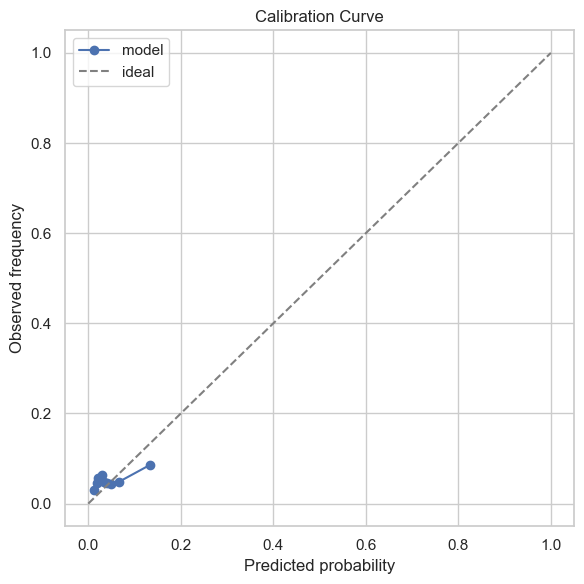

Confusion matrix @0.5 threshold:
[[18530    11]
 [ 1013     8]]


In [7]:
prob_true, prob_pred = calibration_curve(y_test, best_scores, n_bins=10, strategy='quantile')
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='model')
plt.plot([0, 1], [0, 1], '--', color='gray', label='ideal')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / '03_calibration_curve.png', dpi=150)
plt.show()

pred = (best_scores >= 0.5).astype(int)
print('Confusion matrix @0.5 threshold:')
print(confusion_matrix(y_test, pred))


Top global features:
                        feature  importance
num__seller_processing_q80_hist    0.034642
      num__route_late_rate_hist    0.014982
          num__purchase_weekday    0.011284
         cat__customer_state_MG    0.005908
    num__route_transit_q80_hist    0.004892
        num__seller_volume_hist    0.003214
          num__order_item_count    0.001265
                 num__leg_price    0.000988
         num__route_volume_hist    0.000927
         cat__customer_state_CE    0.000594
           cat__seller_state_SP    0.000576
         cat__customer_state_BA    0.000385
            cat__price_band_mid    0.000378
           cat__seller_state_BA    0.000265
         cat__customer_state_PR    0.000211


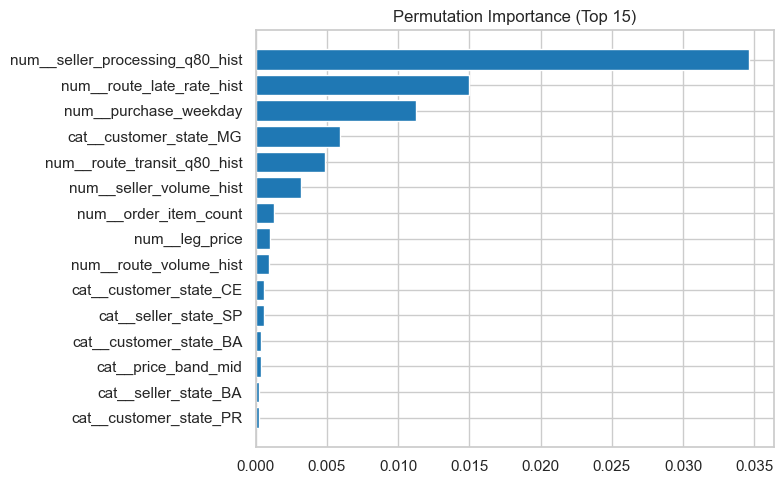

In [8]:
# Explainability with permutation importance on selected model
feature_names = prep.get_feature_names_out()
base_model = hgb if best_name == 'hist_gradient_boosting' else logit.named_steps['clf']
X_eval = X_test_enc if best_name == 'hist_gradient_boosting' else prep.transform(X_test)
perm = permutation_importance(base_model, X_eval, y_test, scoring='roc_auc', n_repeats=5, random_state=42)
imp = pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean}).sort_values('importance', ascending=False).head(15)
print('Top global features:')
print(imp.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.barh(imp['feature'][::-1], imp['importance'][::-1], color='#1f78b4')
plt.title('Permutation Importance (Top 15)')
plt.tight_layout()
plt.savefig(fig_dir / '03_permutation_importance.png', dpi=150)
plt.show()


In [9]:
result = test_df[['order_id','seller_id','seller_state','customer_state','actual_delivery_days','estimated_delivery_days','delay_days']].copy()
result['risk_score'] = best_scores

print('High-risk examples:')
print(result.sort_values('risk_score', ascending=False).head(3).to_string(index=False))
print('Low-risk examples:')
print(result.sort_values('risk_score', ascending=True).head(3).to_string(index=False))

simulation, policy = simulate_hybrid_edd(test_df.copy(), pd.Series(best_scores, index=test_df.index), quantile_level=0.8)
print('Hybrid EDD policy metrics:')
print(policy.round(4).to_string(index=False))

bands = simulation['base_eta_days'].quantile([0.5, 0.8, 0.9])
print('ETA confidence bands (days):')
print(bands.rename(index={0.5:'P50',0.8:'P80',0.9:'P90'}).round(3).to_string())


High-risk examples:
                        order_id                        seller_id seller_state customer_state  actual_delivery_days  estimated_delivery_days  delay_days  risk_score
9ca4233f35ec6058f6642a8124c8f9d2 06a2c3af7b3aee5d69171b0e14f0ee87           MA             MA             17.841389                26.043843   -8.202454    0.701307
0113affd907a209209ab08413bb54226 06a2c3af7b3aee5d69171b0e14f0ee87           MA             TO             21.902627                27.134155   -5.231528    0.694706
3204d768f424c527945af498dfdc005f 06a2c3af7b3aee5d69171b0e14f0ee87           MA             MA              4.915035                22.305000  -17.389965    0.665159
Low-risk examples:
                        order_id                        seller_id seller_state customer_state  actual_delivery_days  estimated_delivery_days  delay_days  risk_score
943f6c7b262e40ec0526ff87156fb401 3c010235b7345c92f125d14ee232a76b           PR             RO             15.871088                22.29

## Stakeholder Translation
- Operations: target high seller-processing contributors for SLA coaching.
- Logistics: escalate high carrier-transit routes with persistent failure rates.
- Product/CX: expose confidence-band ETA messaging to improve expectation setting.
